In [1]:
import tempfile

import matplotlib.pyplot as plt
import muon
import numpy as np
import scanpy as sc
import scvi
import seaborn as sns
import torch
import os 
import pandas as pd

/opt/modules/i12g/anaconda/envs/scooby_reproducibility/lib/python3.9/site-packages/docrep/decorators.py:43: SyntaxWarning: 'param_size_factor_key_expr' is not a valid key!
  doc = func(self, args[0].__doc__, *args[1:], **kwargs)
/opt/modules/i12g/anaconda/envs/scooby_reproducibility/lib/python3.9/site-packages/docrep/decorators.py:43: SyntaxWarning: 'param_size_factor_key_acc' is not a valid key!
  doc = func(self, args[0].__doc__, *args[1:], **kwargs)


In [2]:
scvi.settings.seed = 0
print("Last run with scvi-tools version:", scvi.__version__)

[rank: 0] Seed set to 0


Last run with scvi-tools version: 1.1.3


In [3]:
sc.set_figure_params(figsize=(6, 6), frameon=False)
sns.set_theme()
torch.set_float32_matmul_precision("high")
save_dir = tempfile.TemporaryDirectory()

%config InlineBackend.print_figure_kwargs={"facecolor": "w"}
%config InlineBackend.figure_format="retina"

In [4]:
data_path = '/s/project/QNA/scborzoi/submission_data/'
adata = sc.read(os.path.join(data_path, 'bmmc_multiome_multivi_neurips21_curated_new_palantir_fixed.h5ad'))

In [5]:
adata = adata[:,adata.var.feature_types == 'ATAC']

In [6]:
adata.var['gene_ids'] = adata.var.index.values

/scratch/tmp/martensl/ipykernel_3754165/1044962440.py:1: ImplicitModificationWarning: Trying to modify attribute `.var` of view, initializing view as actual.
  adata.var['gene_ids'] = adata.var.index.values


In [7]:
split_interval = adata.var["gene_ids"].str.split("-", expand=True)
adata.var["chr"] = split_interval[0]
adata.var["start"] = split_interval[1].astype(int)
adata.var["end"] = split_interval[2].astype(int)

In [8]:
mask = adata.var["chr"].str.startswith("chr")
adata = adata[:, mask].copy()

In [9]:
scvi.data.add_dna_sequence(
    adata,
    genome_name="GRCh38",
    genome_dir="data",
    chr_var_key="chr",
    start_var_key="start",
    end_var_key="end",
)
adata

16:57:58 | INFO | Downloading assembly summaries from GENCODE
16:58:08 | INFO | Downloading assembly summaries from UCSC
16:58:14 | INFO | Downloading genome from GENCODE. Target URL: https://hgdownload.soe.ucsc.edu/goldenPath/hg38/bigZips/hg38.fa.gz...


Download:   0%|          | 0.00/938M [00:00<?, ?B/s]

16:59:11 | INFO | Genome download successful, starting post processing...
16:59:26 | INFO | name: hg38
16:59:26 | INFO | local name: GRCh38
16:59:26 | INFO | fasta: /data/ceph/hdd/project/node_09/semi_supervised_multispecies/Downstream/single_cell/code/scooby_reproducibility/notebooks/figure3/data/GRCh38/GRCh38.fa


Filtering Fasta: 0.00 lines [00:00, ? lines/s]

Working...: 100%|██████████| 24/24 [00:05<00:00,  4.49it/s]


AnnData object with n_obs × n_vars = 63683 × 116468
    obs: 'GEX_pct_counts_mt', 'GEX_n_counts', 'GEX_n_genes', 'GEX_size_factors', 'GEX_phase', 'GEX_pseudotime_order', 'ATAC_nCount_peaks', 'ATAC_atac_fragments', 'ATAC_reads_in_peaks_frac', 'ATAC_pseudotime_order', 'DonorID', 'VendorLot', 'DonorAge', 'DonorBMI', 'DonorBloodType', 'DonorRace', 'Ethnicity', 'DonorGender', 'QCMeds', 'DonorSmoker', 'modality', 'site', 'donor', 'batch', 'l1_cell_type', 'l2_cell_type', 'neurips21_cell_type', 'frag_file_bcs', 'palantir_pseudotime', 'palantir_entropy', 'doublet_score', 'leiden', 'is_doublet', 'dpt_pseudotime'
    var: 'gene_ids', 'feature_types', 'hvg_multiVI', 'chr', 'start', 'end'
    uns: 'ATAC_gene_activity_var_names', 'DM_EigenValues', '_scvi', 'dataset_id', 'diffmap_evals', 'genome', 'iroot', 'is_doublet_colors', 'l2_cell_type_colors', 'leiden', 'leiden_colors', 'neighbors', 'neighbors_poisson', 'organism', 'palantir_waypoints', 'umap'
    obsm: 'ATAC_gene_activity', 'DM_EigenVectors', 

In [10]:
adata.varm["dna_sequence"]

,0,1,2,3,4,5,6,7,8,9,...,1334,1335,1336,1337,1338,1339,1340,1341,1342,1343
chr1-9776-10668,N,N,N,N,N,N,N,N,N,N,...,C,C,G,C,G,T,C,C,A,G
chr1-180726-181005,C,T,T,A,C,C,C,T,T,A,...,G,G,G,G,T,T,G,G,G,G
chr1-181117-181803,T,A,A,C,C,C,T,A,A,C,...,A,C,C,A,G,C,A,A,T,G
chr1-191133-192055,G,C,A,G,A,G,T,C,C,A,...,G,C,A,G,C,G,C,T,G,T
chr1-267562-268456,C,A,A,T,T,C,C,G,G,G,...,G,T,T,G,T,G,T,T,C,T
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
chrX-156001265-156002117,C,A,G,A,G,A,A,C,T,T,...,A,A,A,A,A,A,T,T,T,G
chrX-156029992-156030883,G,A,T,T,C,T,C,C,C,A,...,N,N,N,N,N,N,N,N,N,N
chrY-11295162-11295942,T,T,C,C,A,C,T,C,C,A,...,T,T,C,C,A,T,T,T,C,A
chrY-11333659-11334343,C,C,A,G,C,C,C,A,T,G,...,T,T,T,G,G,G,A,G,T,T


In [11]:
bdata = adata.transpose()
bdata.layers["binary"] = (bdata.X.copy() > 0).astype(float)
scvi.external.SCBASSET.setup_anndata(bdata, layer="binary", dna_code_key="dna_code")

An NVIDIA GPU may be present on this machine, but a CUDA-enabled jaxlib is not installed. Falling back to cpu.
/opt/modules/i12g/anaconda/envs/scooby_reproducibility/lib/python3.9/site-packages/scvi/data/fields/_layer_field.py:116: UserWarning: Training will be faster when sparse matrix is formatted as CSR. It is safe to cast before model initialization.
  _verify_and_correct_data_format(adata, self.attr_name, self.attr_key)


INFO     Using column names from columns of adata.obsm['dna_code']                                                 


In [12]:
bdata.layers['binary'] = bdata.layers['binary'].tocsr()

In [13]:
bdata.layers['binary']

<116468x63683 sparse matrix of type '<class 'numpy.float64'>'
	with 214234651 stored elements in Compressed Sparse Row format>

In [14]:
bdata.obsm['dna_sequence'].columns = bdata.obsm['dna_sequence'].columns.astype(str)

### Train scBasset

In [ ]:
from lightning.pytorch.loggers import WandbLogger
import wandb

wandb_logger = WandbLogger(project="scBasset", entity='lauradm')

In [19]:
bas = scvi.external.SCBASSET(bdata)
bas.train(precision='16-mixed', logger = logger)

/opt/modules/i12g/anaconda/envs/scvi-tools-1/lib/python3.12/site-packages/lightning/fabric/plugins/environments/slurm.py:204: The `srun` command is available on your system but is not used. HINT: If your intention is to run Lightning on SLURM, prepend your python command with `srun` like so: srun python /opt/modules/i12g/anaconda/envs/scvi-tools-1/lib/pyt ...
Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
/opt/modules/i12g/anaconda/envs/scvi-tools-1/lib/python3.12/site-packages/lightning/fabric/plugins/environments/slurm.py:204: The `srun` command is available on your system but is not used. HINT: If your intention is to run Lightning on SLURM, prepend your python command with `srun` like so: srun python /opt/modules/i12g/anaconda/envs/scvi-tools-1/lib/pyt ...
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/opt/modules/i12g/anaconda/envs/scvi-t

Epoch 10/1000:   1%|          | 9/1000 [04:14<7:36:07, 27.62s/it, v_num=1, train_loss_step=0.11, train_loss_epoch=0.108] 

/opt/modules/i12g/anaconda/envs/scvi-tools-1/lib/python3.12/site-packages/lightning/pytorch/trainer/call.py:54: Detected KeyboardInterrupt, attempting graceful shutdown...


<Axes: xlabel='epoch'>

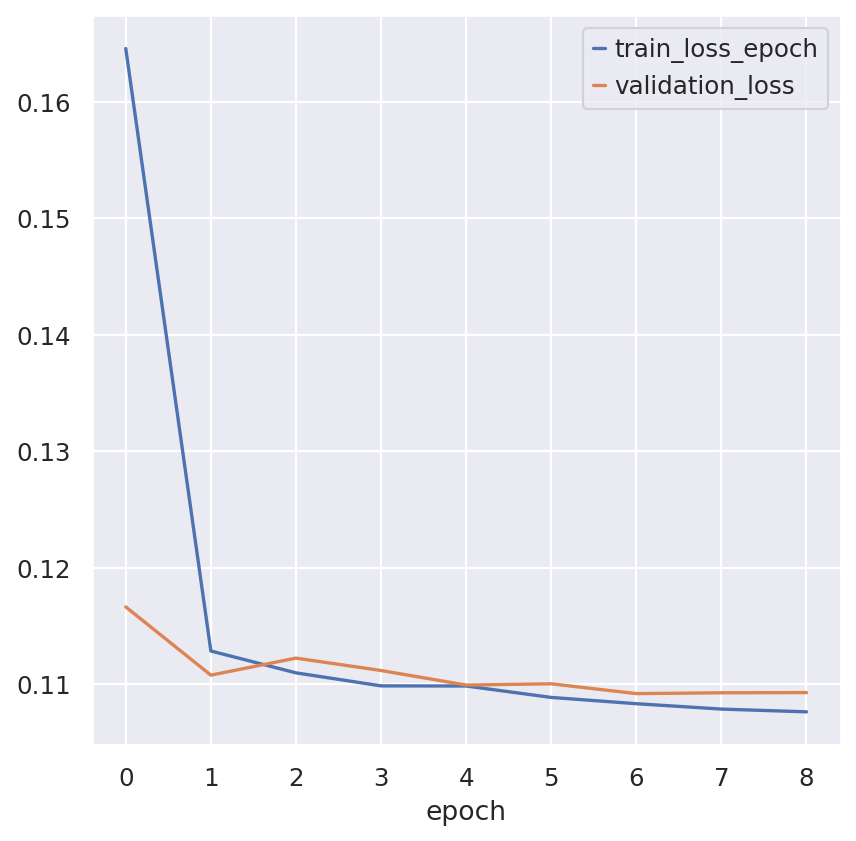

In [20]:
fig, ax = plt.subplots()
bas.history_["train_loss_epoch"].plot(ax=ax)
bas.history_["validation_loss"].plot(ax=ax)

In [ ]:
fig, ax = plt.subplots()
bas.history_["auroc_train"].plot(ax=ax)
bas.history_["auroc_validation"].plot(ax=ax)

### Eval scBasset

In [15]:
bas = scvi.external.SCBASSET.load(os.path.join(data_path, 'motif_effects', 'scBasset', 'model_attempt_overnight.pt/'), adata = bdata)

INFO     File /s/project/QNA/scborzoi/submission_data/motif_effects/scBasset/model_attempt_overnight.pt/model.pt   
         already downloaded                                                                                        


/opt/modules/i12g/anaconda/envs/scooby_reproducibility/lib/python3.9/site-packages/scvi/model/base/_save_load.py:67: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model = to

In [16]:
tfs = pd.read_csv(os.path.join(data_path, 'motif_effects', "multiome_run.csv"), header = None)[0].tolist()

In [17]:
for tf in tfs:
    try:
        adata.obs[f"bas_{tf}"] = bas.get_tf_activity(
            tf=tf,
            motif_dir="data/motifs",
        )
    except:
        print (tf)

INFO     Downloading motif set to: data/motifs                                                                     
INFO     Downloading file at data/motifs/human_motifs.tar.gz                                                       
Downloading...: 100%|██████████| 306466/306466.0 [00:10<00:00, 30233.83it/s]
INFO     Download and extraction complete.                                                                         
multiome
TRPS1
TEAD2
COE1
MBNL2
ZEB2


In [26]:
adata.varm = None

In [27]:
adata.obsm = None
adata.write(os.path.join(data_path, 'motif_effects', 'scBasset', "adata_w_tf_activity.h5ad"))